# 使用神经网络解决问题

In [3]:
import sys
sys.path.append('..') # 为了引入父目录的文件而进行的设定
from dataset import spiral
import matplotlib.pyplot as plt

x,t = spiral.load_data()
print('x',x.shape)# (300,2)
print('y',t.shape)# (300,3)


x (300, 2)
y (300, 3)


在上面的例子中，要从ch01目录的dataset目录引入spiral.py。因此，上面的代码通过sys.path.append（'..'）将父目录添加到了import的检索路径中。

In [4]:
print(x)
print(t)

[[-0.00000000e+00  0.00000000e+00]
 [-9.76986432e-04  9.95216044e-03]
 [ 5.12668241e-03  1.93317647e-02]
 [-3.86043324e-04  2.99975161e-02]
 [ 1.42509650e-02  3.73752591e-02]
 [ 9.41914082e-04  4.99911272e-02]
 [ 2.25361319e-02  5.56068589e-02]
 [ 6.52848904e-03  6.96948982e-02]
 [ 2.50649535e-02  7.59720219e-02]
 [ 2.03287580e-02  8.76740646e-02]
 [ 5.98440862e-02  8.01166983e-02]
 [ 6.19050693e-02  9.09272368e-02]
 [ 3.22809763e-02  1.15576549e-01]
 [ 8.28423530e-02  1.00185551e-01]
 [ 1.09856959e-01  8.67839183e-02]
 [ 9.33208222e-02  1.17436043e-01]
 [ 7.82976217e-02  1.39533087e-01]
 [ 1.23994559e-01  1.16298535e-01]
 [ 8.06199110e-02  1.60936105e-01]
 [ 1.39235917e-01  1.29280158e-01]
 [ 1.53599653e-01  1.28090384e-01]
 [ 1.38981638e-01  1.57429680e-01]
 [ 1.89873275e-01  1.11122183e-01]
 [ 1.41160729e-01  1.81586477e-01]
 [ 1.50631465e-01  1.86842613e-01]
 [ 1.71714639e-01  1.81697778e-01]
 [ 2.10050449e-01  1.53227963e-01]
 [ 2.32019716e-01  1.38082770e-01]
 [ 2.31219125e-01  1

此时，x是输入数据， t是监督标签。观察x和t的形状，可知它们各自有300笔样本数据，其中x是二维数据，t是三维数据。另外，t是one-hot向量，对应的正确解标签的类标记为1，其余的标记为0。下面，我们把这些数据绘制在图上，结果如图1-31所示。

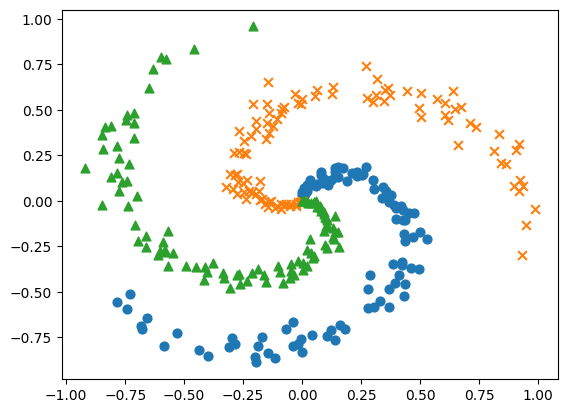

In [5]:
# 绘制数据点
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

如图1-31所示，输入是二维数据，类别数是3。观察这个数据集可知，它不能被直线分割。因此，我们需要学习非线性的分割线。那么，我们的神经网络（具有使用非线性的sigmoid激活函数的隐藏层的神经网络）能否正确学习这种非线性模式呢？让我们实验一下。

### Tip:数据集划分

因为这个实验相对简单，所以我们不把数据集分成训练数据、验证数据和测试数据。不过，实际任务中会将数据集分为训练数据和测试数据（以及验证数据）来进行学习和评估。

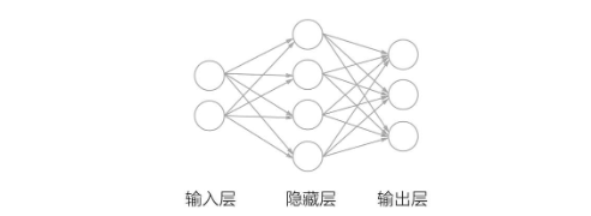

In [6]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import Affine,Sigmoid,SoftmaxWithLoss

class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size):
        I,H,O = input_size,hidden_size,output_size
        # 初始化权重和偏置
        W1 = 0.01*np.random.randn(I,H)# (1,I)*(I,H)
        b1 = np.zeros(H)
        W2 = 0.01*np.random.randn(H,O)# (1,H)*(H,O)
        b2 = np.zeros(O)
        # 生成层
        self.layers = [
            Affine(W1,b1),
            Sigmoid(),
            Affine(W2,b2)
        ]
        # 损失函数
        self.loss_layer = SoftmaxWithLoss()
        # 将所有的权重和梯度整理到列表中
        self.params, self.grads = [],[]
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def forward(self,x,t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score,t)
        return loss
    
    def backward(self,dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):# 反向传播
            dout = layer.backward(dout)
        return dout
    

初始化程序接收3个参数。input_size是输入层的神经元数，hidden_size是隐藏层的神经元数，output_size是输出层的神经元数。在内部实现中，首先用零向量（np.zeros（​）​）初始化偏置，再用小的随机数（0.01 *np.random.randn（​）​）初始化权重。通过将权重设成小的随机数，学习可以更容易地进行。接着，生成必要的层，并将它们整理到实例变量layers列表中。最后，将这个模型使用到的参数和梯度归纳在一起。

### 学习使用的代码

In [8]:
# 学习使用的代码
import sys
sys.path.append('..')
import numpy as np
from common.optimizer import SGD
from dataset import spiral
import matplotlib.pyplot as plt
# from two_layer_net import TwoLayerNet

# 设定超参数
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

# 读入数据，生成模型和优化器
x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 学习用的变量
data_size = len(x)
max_iters = data_size // batch_size  # 每个epoch中的批次数
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    # 打乱数据
    idx = np.random.permutation(data_size)
    x = x[idx]  # data sample
    t = t[idx]  # data label

    for iters in range(max_iters):
        batch_x = x[iters * batch_size:(iters + 1) * batch_size]
        batch_t = t[iters * batch_size:(iters + 1) * batch_size]

        # 确保batch_x和batch_t都是二维数组
        if batch_x.ndim == 1:
            batch_x = batch_x.reshape(1, -1)  # 如果是1D数组，变成2D（1, 特征数）
        if batch_t.ndim == 1:
            batch_t = batch_t.reshape(1, -1)  # 如果是1D数组，变成2D（1, 类别数）

        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 定期输出学习过程
    if (iters + 1) % 10 == 0:
        avg_loss = total_loss / loss_count
        print('|epoch %d | iter %d / %d | loss %.2f' % (epoch + 1, iters + 1, max_iters, avg_loss))
        loss_list.append(avg_loss)
        total_loss, loss_count = 0, 0

|epoch 1 | iter 10 / 10 | loss 1.13
|epoch 2 | iter 10 / 10 | loss 1.13
|epoch 3 | iter 10 / 10 | loss 1.12
|epoch 4 | iter 10 / 10 | loss 1.12
|epoch 5 | iter 10 / 10 | loss 1.11
|epoch 6 | iter 10 / 10 | loss 1.14
|epoch 7 | iter 10 / 10 | loss 1.16
|epoch 8 | iter 10 / 10 | loss 1.11
|epoch 9 | iter 10 / 10 | loss 1.12
|epoch 10 | iter 10 / 10 | loss 1.13
|epoch 11 | iter 10 / 10 | loss 1.12
|epoch 12 | iter 10 / 10 | loss 1.11
|epoch 13 | iter 10 / 10 | loss 1.09
|epoch 14 | iter 10 / 10 | loss 1.08
|epoch 15 | iter 10 / 10 | loss 1.04
|epoch 16 | iter 10 / 10 | loss 1.03
|epoch 17 | iter 10 / 10 | loss 0.96
|epoch 18 | iter 10 / 10 | loss 0.92
|epoch 19 | iter 10 / 10 | loss 0.92
|epoch 20 | iter 10 / 10 | loss 0.87
|epoch 21 | iter 10 / 10 | loss 0.85
|epoch 22 | iter 10 / 10 | loss 0.82
|epoch 23 | iter 10 / 10 | loss 0.79
|epoch 24 | iter 10 / 10 | loss 0.78
|epoch 25 | iter 10 / 10 | loss 0.82
|epoch 26 | iter 10 / 10 | loss 0.78
|epoch 27 | iter 10 / 10 | loss 0.76
|epoch 28 

### Tip:epoch

Epoch表示学习的单位。1个epoch相当于模型“看过”一遍所有的学习数据（遍历数据集）​。这里我们进行300个epoch的学习。

### Tip:数据打乱

在进行学习时，需要随机选择数据作为mini-batch。这里，我们以epoch为单位打乱数据，对于打乱后的数据，按顺序从头开始抽取数据。数据的打乱（准确地说，是数据索引的打乱）使用np.random.permutation（​）方法。给定参数N，该方法可以返回0到N-1的随机序列，其实际的使用示例如下所示。

In [9]:
import numpy as np
np.random.permutation(10)

array([5, 1, 8, 4, 9, 7, 0, 2, 6, 3])

In [10]:
np.random.permutation(10)

array([3, 4, 2, 7, 8, 5, 6, 0, 9, 1])

像这样，调用np.random.permutation（​）可以随机打乱数据的索引。

In [12]:
loss_list

[1.1256062166823237,
 1.1255202354489933,
 1.1162613752115285,
 1.1162867078413503,
 1.1123000112951948,
 1.1384639824108038,
 1.1590961883070312,
 1.1086316143023154,
 1.1173305676924539,
 1.1287957712269248,
 1.1168438089353867,
 1.108338779101816,
 1.0876149200499459,
 1.076681386581935,
 1.0442376735950387,
 1.0345782626337772,
 0.9572932039643971,
 0.918385321087945,
 0.9241491096212101,
 0.8685139076509195,
 0.849380704784154,
 0.8171629191788113,
 0.7924414711357766,
 0.7826646392986113,
 0.8235432039035636,
 0.7754573601774306,
 0.7557857636797779,
 0.7644773546985875,
 0.783489908441849,
 0.7507895610696304,
 0.7773067036165259,
 0.7650839562418821,
 0.7727897179944694,
 0.7819402998382252,
 0.7479802970891092,
 0.7449918634368045,
 0.7560347486336814,
 0.762136567723541,
 0.7308895411004578,
 0.7530268898576871,
 0.7598416342022494,
 0.7594443798911804,
 0.7609245612331736,
 0.7385235003122192,
 0.7483287079215573,
 0.732212322256757,
 0.7226947264484566,
 0.7329453633807874,

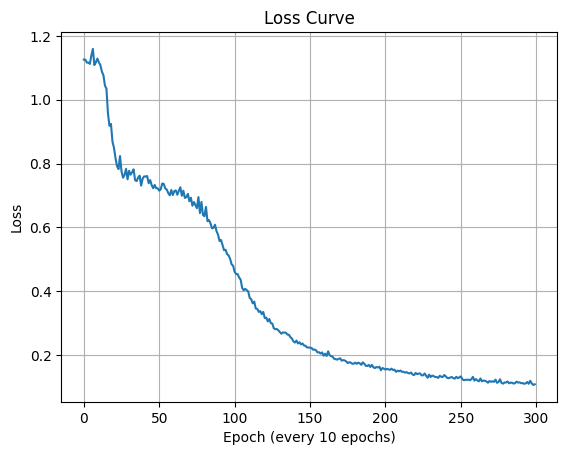

In [11]:
# 绘制损失曲线
plt.plot(loss_list)
plt.xlabel('Epoch (every 10 epochs)')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid()
plt.show()

### Trainer类


如前所述，本书中有很多机会执行神经网络的学习。为此，就需要编写前面那样的学习用的代码。然而，每次都写相同的代码太无聊了，因此我们将进行学习的类作为Trainer类提供出来。Trainer类的内部实现和刚才的源代码几乎相同，只是添加了一些新的功能而已，我们在需要的时候再详细说明其用法。

这个类的初始化程序接收神经网络（模型）和优化器，具体如下所示。

In [13]:
# model = TwoLayerNet(...)
# optimizer = SGD(lr=1.0)
# trainer = Trainer(model,optimizer)

然后，调用fit（​）方法开始学习。fit（​）方法的参数如表1-1所示。

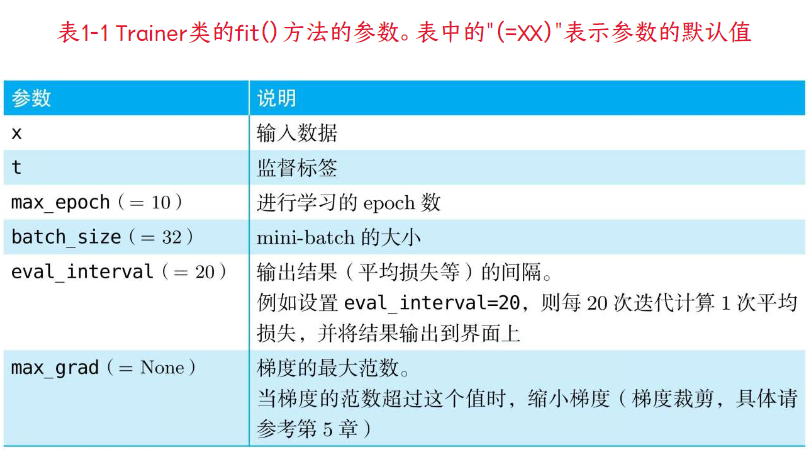

另外，Trainer类有plot（​）方法，它将fit（​）方法记录的损失（准确地说，是按照eval_interval评价的平均损失）在图上画出来。使用Trainer类进行学习的代码如下所示

| epoch 1 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 2 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 3 |  iter 1 / 10 | time 0[s] | loss 1.13
| epoch 4 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 5 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 6 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 7 |  iter 1 / 10 | time 0[s] | loss 1.14
| epoch 8 |  iter 1 / 10 | time 0[s] | loss 1.16
| epoch 9 |  iter 1 / 10 | time 0[s] | loss 1.11
| epoch 10 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 11 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 12 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 13 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 14 |  iter 1 / 10 | time 0[s] | loss 1.09
| epoch 15 |  iter 1 / 10 | time 0[s] | loss 1.08
| epoch 16 |  iter 1 / 10 | time 0[s] | loss 1.04
| epoch 17 |  iter 1 / 10 | time 0[s] | loss 1.03
| epoch 18 |  iter 1 / 10 | time 0[s] | loss 0.94
| epoch 19 |  iter 1 / 10 | time 0[s] | loss 0.92
| epoch 20 |  iter 1 / 10 | time 0[s] | loss 0.92
| epoch 2

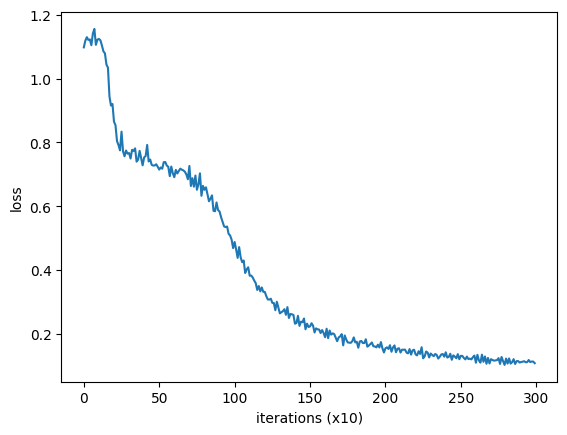

In [14]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import Trainer
from dataset import spiral
# from two_layer_net import TwoLayerNet

max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x,t = spiral.load_data()

model = TwoLayerNet(input_size=2,hidden_size=hidden_size,output_size=3)

optimizer = SGD(lr=learning_rate)
trainer = Trainer(model,optimizer)
trainer.fit(x,t,max_epoch,batch_size,eval_interval=10)
trainer.plot()





执行这段代码，会进行和之前一样的神经网络的学习。通过将之前展示的学习用的代码交给Trainer类负责，代码变简洁了。本书今后都将使用Trainer类进行学习。

# 高速化计算

安装NVIDIA Cuda管理器，并使用Cupy调用GPU进行告高速计算。

https://baijiahao.baidu.com/s?id=1781877547348944869&wfr=spider&for=pc